In [2]:
import torch
import torch.cuda
import numpy as np

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import random
seed_everything(random.randint(1, 10000))

In [5]:
import pandas as pd

df = pd.read_csv('./imdb_master.csv', encoding="latin-1")
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [6]:
df = df.drop(['Unnamed: 0', 'type', 'file'], axis=1)
df.columns = ['review', 'label']
df.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [7]:
# В датасете присутствуют отзывы, неразмеченные как положительные или отрицательные
df = df[df.label != 'unsup']
df['label'] = df['label'].map({'pos': 1, 'neg': 0})
df.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [8]:
df.shape

(50000, 2)

In [9]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

In [10]:
df['processed_review'] = df.review.apply(lambda x: clean_text(x))
df.head()

,review,label,processed_review
0,Once again Mr. Costner has dragged out a movie...,0,mr costner ha drag movie far longer necessary ...
1,This is an example of why the majority of acti...,0,example majority action film generic bore real...
2,"First of all I hate those moronic rappers, who...",0,first hate moronic rapper couldnt act gun pres...
3,Not even the Beatles could write songs everyon...,0,even beatles could write song everyone like al...
4,Brass pictures (movies is not a fitting word f...,0,brass picture movie fit word really somewhat b...


In [11]:
df = df.drop(['review'], axis=1)
df.processed_review.apply(lambda x: len(x.split(" "))).mean()

127.99056

In [12]:
val_frac = 0.4
val_split_idx = int(len(df)*val_frac) #index on which to split
data_idx = list(range(len(df))) #create a list of ints till len of data
np.random.shuffle(data_idx)

val_idx, train_idx = data_idx[:val_split_idx], data_idx[val_split_idx:]
print('len of train: ', len(train_idx))
print('len of val: ', len(val_idx))

train = df.iloc[train_idx].reset_index().drop('index',axis=1)
test = df.iloc[val_idx].reset_index().drop('index',axis=1)

len of train:  30000
len of val:  20000


In [13]:
train.head()

,label,processed_review
0,1,order pull job like caper rififi eg score opin...
1,0,time get psycho toy maker name joe petto get m...
2,0,group cavers sad history take author hairy adv...
3,0,love first little mermaid know song love chara...
4,1,better typical madefortv movie invitation hell...


In [14]:
from torchdata.datapipes.iter import IterableWrapper, Mapper, ShardingFilter
train_set = IterableWrapper(list(map(tuple, train.to_numpy())))
test_set = IterableWrapper(list(map(tuple, test.to_numpy())))

train_iter = ShardingFilter(train_set)
test_iter = ShardingFilter(test_set)

In [15]:
#from torchtext.datasets import IMDB

#train_iter, test_iter = IMDB()

In [16]:
type(train_iter)

torch.utils.data.datapipes.iter.sharding.ShardingFilterIterDataPipe

In [17]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_iter]), min_freq=3, specials=["<UNK>"])
#vocab = build_vocab_from_iterator(build_vocabulary([train_iter, test_iter]), min_freq=10, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

In [18]:
def save_vocab(vocab):
    import pickle
    output = open('vocab.pkl', 'wb')
    pickle.dump(vocab, output)
    output.close()

save_vocab(vocab)

In [19]:
len(vocab)

39642

In [20]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = to_map_style_dataset(train_iter), to_map_style_dataset(test_iter)

target_classes = ["negative", "positive"]

max_words = 150

In [21]:
train_dataset[3]

(0,
 'love first little mermaid know song love character love story cant say anything like little mermaid ii return sea wa terrible let start story plot wa reverse copy first movie situation except reverse ariel want live land daughter melody creative name want live sea ariel wa trick ursula melody trick ursulas sister morgana ursula sister sure come besides strange copy first movie movie plot seem tire wa uninteresting compare first movie character 1 ariel happen longer spunky, headstrong teenager know love first movie, ha "grown up" personality go drain. sing voice strong either, due either jodi benson lot older, song terrible talent wa wasted. 2. prince eric- lot personality first movie, like disney princes, somehow new voice line make even robotic. top off, can\'t seem defend himself, ariel become tough one two. 3. sebastian- say goodbye lovable crustacean first movie, whiny, aggravate little crab take place. also good song movie. almost forget glory earn sing incredible "under sea

In [22]:
train_dataset[10000]

(0,
 'watch hop find something didnt know modern history infamous man couldnt help think history ha rewrite hitlerthe rise evil  hitler wa obsess niece threaten one admirer shoot  hitler turn gun hand arrest ernst rohm  forgive ask havent writer confuse adolph hitler tony montana scarface  thats bad enough really offend wa entire chunk historical context miss mini series  germany lose first world war ally power make germany pay heavy price wa economic environment lead german people someone  anyone  restore pride thats turn nazism  german humiliation 1920s cause ally power seem entirely miss therefore way hitlerthe rise evil take seriously historical document havent even mention himmler goering conspicous absence br br one positive point mini series thats robert carlyle title role  okay mannerism wrong voice little loud  archive record show hitler soft seductive voice  carlyle charismatic actor doe manage communicate hitler charisma screen . comment british press carlyle resemble synth 

In [23]:
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 

    return torch.tensor(X, dtype=torch.int32).to(device), (torch.tensor(Y)).to(device) 

batch_size = 512 
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, collate_fn=vectorize_batch)

In [24]:
train_dataset

<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x2caa684b550>

In [25]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from torch import flatten

In [49]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Test Loss  : {:.3f}".format(torch.tensor(losses).mean()))
        print("Test Acc   : {:.3f}\n".format(accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())))

def train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs=10, test=False):
    for i in range(1, epochs+1):
        losses = []
        #for X, Y in tqdm(train_loader):
        for X, Y in train_loader:
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        if test:
            CalcValLossAndAccuracy(model, loss_fn, test_loader)

def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    with torch.no_grad():
        for X, Y in loader:
            preds = model(X)
            Y_preds.append(preds)
            Y_shuffled.append(Y)
        gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

def print_results(Y_actual, Y_preds, target_names):
    print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
    print("\nClassification Report : ")
    print(classification_report(Y_actual, Y_preds, target_names=target_classes))
    print("\nConfusion Matrix : ")

    from sklearn.metrics import confusion_matrix
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    import numpy as np

    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def save_model(model, name):
    path = './net_'+ name +'.pth'
    print(path)
    torch.save(model.state_dict(), path)

In [42]:
embed_len = max_words
hidden_dim = 50
n_layers = 1

class RNN_1(nn.Module):
    def __init__(self):
        super(RNN_1, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))
        self.dropout = nn.Dropout(0.25)
        #self.hidden = torch.nn.parameter.Parameter(torch.zeros(n_layers, batch_size, self.hidden_dim, device=device))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)

        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim, device=device))
        return self.linear(output[:,-1])
    
get_n_params(RNN_1())

5956502

Train Loss : 0.710
Test Loss  : 0.707
Test Acc   : 0.503

Train Loss : 0.706
Test Loss  : 0.707
Test Acc   : 0.498

Train Loss : 0.705
Test Loss  : 0.705
Test Acc   : 0.500

Train Loss : 0.704
Test Loss  : 0.705
Test Acc   : 0.499

Train Loss : 0.703
Test Loss  : 0.705
Test Acc   : 0.501

Train Loss : 0.701
Test Loss  : 0.703
Test Acc   : 0.500

Train Loss : 0.701
Test Loss  : 0.702
Test Acc   : 0.504

Train Loss : 0.699
Test Loss  : 0.701
Test Acc   : 0.498

Train Loss : 0.699
Test Loss  : 0.701
Test Acc   : 0.497

Train Loss : 0.699
Test Loss  : 0.700
Test Acc   : 0.502

./net_rnn_simple.pth
Test Accuracy : 0.50145

Classification Report : 
              precision    recall  f1-score   support

    negative       0.50      0.51      0.50      9936
    positive       0.50      0.49      0.50     10064

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000


Confusion Matrix : 


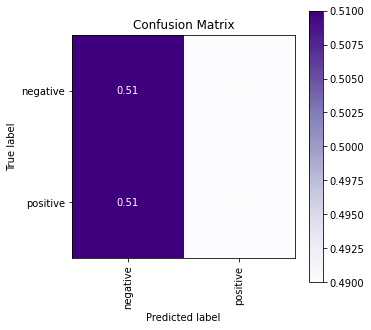

In [50]:
from torch.optim import Adam

epochs = 10
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNN_1().to(device)
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

train_model(rnn_classifier, loss_fn, optimizer, train_loader, test_loader, epochs, test=True)
save_model(rnn_classifier, 'rnn_simple')
gc.collect()
torch.cuda.empty_cache()

Y_actual, Y_preds = MakePredictions(rnn_classifier, test_loader)
print_results(Y_actual, Y_preds, target_classes)

In [51]:
embed_len = max_words
hidden_dim = 50
n_layers=1

class RNN_1(nn.Module):
    def __init__(self):
        super(RNN_1, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(target_classes))
        self.dropout = nn.Dropout(0.25)
        #self.hidden = torch.nn.parameter.Parameter(torch.zeros(n_layers, batch_size, self.hidden_dim, device=device))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)

        output, hidden = self.rnn(embeddings, torch.randn(n_layers, len(X_batch), hidden_dim, device=device))
        x = self.dropout(output)
        x = self.linear(x[:,-1])
        return x
    
get_n_params(RNN_1())

5956502

In [52]:
class Net_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(10, 25, 5)  
        self.pool = nn.MaxPool2d(2, 2) # 61, 61, 30
        self.do1 = nn.Dropout(0.2) 
        self.fc1 = nn.Linear(61 * 61 * 25, 500)
        self.do2 = nn.Dropout(0.3) 
        self.fc2 = nn.Linear(500, 2)
        self.fc3 = nn.Softmax(dim = 1)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.do1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.do2(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [53]:
class Net_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) # 252, 252, 10
        self.conv2 = nn.Conv2d(10, 10, 5) # 248, 248, 10
        self.pool = nn.MaxPool2d(2, 2) # 124, 124, 10
        self.conv3 = nn.Conv2d(10, 12, 5) # 120, 120, 10
        self.pool = nn.MaxPool2d(2, 2) # 60, 60, 20
        self.do1 = nn.Dropout(0.2) 
        self.fc1 = nn.Linear(60 * 60 * 12, 800)
        self.do2 = nn.Dropout(0.2) 
        self.fc2 = nn.Linear(800, 80)
        self.fc3 = nn.Linear(80, 2)
        self.fc4 = nn.Softmax(dim = 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.do1(x)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.do2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [54]:
class Net_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2) 
        self.do1 = nn.Dropout(0.2) 
        self.fc1 = nn.Linear(158760, 500)
        self.do2 = nn.Dropout(0.3) 
        self.fc2 = nn.Linear(500, 200)
        self.do3 = nn.Dropout(0.2) 
        self.fc3 = nn.Linear(200, 100)
        self.do4 = nn.Dropout(0.2) 
        self.fc4 = nn.Linear(100, 2)
        self.fc5 = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.do1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.do2(x)
        x = F.relu(self.fc2(x))
        x = self.do3(x)
        x = F.relu(self.fc3(x))
        x = self.do4(x) 
        x = self.fc4(x)
        x = self.fc5(x)
        
        return x

In [55]:
nets = [] 
nets.append(Net_1())
nets.append(Net_2())
nets.append(Net_3())
nets.append(Net_4())

NameError: name 'Net_1' is not defined

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

In [ ]:
for i, net in enumerate(nets):
    print(f'---- net {i} ----')
    print(type(net))
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(4): 
        running_loss = 0.0
        for j, data in enumerate(train_loader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if j % 30 == 29: 
                print(f'[{epoch + 1}, {j + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0
    print('Finished Training')

    #Сохранение нашей модели
    path = './cats_net_'+ str(i) +'.pth'
    print(path)
    torch.save(net.state_dict(), path)

    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    outputs = net(images)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {test_len} test images: {100 * correct // total} %')

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    param_count = get_n_params(net)
    print(f'Model size: {param_count} parametres')

In [ ]:
nets = []
net_1 = Net_1()
net_1.load_state_dict(torch.load('cats_net_0.pth'))
nets.append(net_1)
net_2 = Net_2()
net_2.load_state_dict(torch.load('cats_net_1.pth'))
nets.append(net_2)
net_3 = Net_3()
net_3.load_state_dict(torch.load('cats_net_2.pth'))
nets.append(net_3)
net_4 = Net_4()
net_4.load_state_dict(torch.load('cats_net_3.pth'))
nets.append(net_4)

In [ ]:
from PIL import Image
def image_loader(image_name):
    tf_eval = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_name)
    image = tf_eval(image).unsqueeze(0)
    return image

In [ ]:
plt.imshow(Image.open('./lastik_example.jpg')), plt.xticks([]), plt.yticks([])

In [ ]:
image = image_loader('./lastik_example.jpg')

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
def pre_image(image, model, classes):
   with torch.no_grad():
      model.eval()  
      output = model(image)
      index = output.data.cpu().numpy().argmax()
      class_name = classes[index]
      return class_name

In [ ]:
for i, net in enumerate(nets):
    print(f"Net {i} says it's {pre_image(image, net, db.classes)}")